In [3]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K

In [4]:
import sys
sys.path.append('Embeddings/pumap/')
sys.path.append('Embeddings/ptsne/')
from umap.parametric_umap import ParametricUMAP, load_ParametricUMAP
import functions

In [5]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

def plot_embedding(embedding, y_train, title=""):
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    colors = [plt.cm.tab10.colors[i] for i in y_train]
    ax.scatter(embedding[:,0], embedding[:,1], c=colors, s=2)
    ax.set_aspect(1)
    recs = []
    for i in range(0,10):
        recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
    ax.legend(recs,list(range(10)),loc=2)
    plt.title(title)
    plt.show()

# Datasets & Loaders

In [6]:
X_train, y_train, X_test, y_test = functions.get_data("cifar10", base_path="")

In [7]:
X_train.shape, y_train.shape

((50000, 32, 32, 3), (50000,))

In [8]:
X_test.shape, y_test.shape

((10000, 32, 32, 3), (10000,))

# Classifier Network

In [9]:
model = functions.get_model("cifar10", optim=tf.keras.optimizers.Adam())
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 30, 30, 16)        448       
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 32)        4640      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 12, 12, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 6, 6, 64)          0         
_________________________________________________________________
conv4 (Conv2D)               (None, 4, 4, 128)         73856     
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 2, 2, 128)         0

# Train Initial Network

In [10]:
epochs = 5
# tf.random.set_seed(42)

In [10]:

history = model.fit(
    X_train,
    y_train,
    batch_size=50,
    epochs=epochs,
    shuffle=True
)

Train on 50000 samples
Epoch 1/5
   50/50000 [..............................] - ETA: 18:27

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv1/Conv2D (defined at <ipython-input-10-e222488bab73>:6) ]] [Op:__inference_distributed_function_954]

Function call stack:
distributed_function


In [ ]:
history.history

In [ ]:
model.save('models/cifar10-before.h5')

# Embedding

In [11]:
layer_key = 'classifier' # which latent layer output should be used for embedding
# embedding_size = 10 # what's the output size of this layer
#embedding_dim = None#(10) # what is the output dimension

In [12]:
# model = tf.keras.models.load_model("models/cifar10-before.h5")
model = functions.get_model("cifar10", optim=tf.keras.optimizers.Adam())
model.load_weights("models/cifar10-before.h5")

In [13]:
model_sub = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer(layer_key).output)
# model_sub.summary()

In [14]:
logits_train = model_sub.predict(X_train)
logits_test = model_sub.predict(X_test)

In [ ]:
# logits_train.shape

In [28]:
import numpy as np
# tf.random.set_seed(42)

embedder = ParametricUMAP(optimizer=tf.keras.optimizers.Adam(),
        batch_size=500,
        dims=None,
        encoder=None, # you could enter another network here
        loss_report_frequency=10,
        n_training_epochs=2,
        verbose=True)
embedder.fit(logits_train[::12]) # why is only subset used?

ParametricUMAP(batch_size=500, n_training_epochs=2,
               optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x0000020482A3C748>)
Construct fuzzy simplicial set
Tue Oct 27 13:06:40 2020 Finding Nearest Neighbors
Tue Oct 27 13:06:40 2020 Building RP forest with 8 trees
Tue Oct 27 13:06:40 2020 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	Stopping threshold met -- exiting after 3 iterations
Tue Oct 27 13:06:40 2020 Finished Nearest Neighbor Search
Tue Oct 27 13:06:40 2020 Construct embedding


Embeddings/pumap\umap\parametric_umap.py:271: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  "Data should be scaled to the range 0-1 for cross-entropy reconstruction loss."


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Cell is empty
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Cell is empty
Train for 110 steps
Epoch 1/20
110/110 [==============================] - 2s 18ms/step - loss: 0.2499
Epoch 2/20
110/110 [==============================] - 1s 7ms/step - loss: 0.2206
Epoch 3/20
110/110 [==============================] - 1s 8ms/step - loss: 0.2183
Epoch 4/20
110/110 [==============================] - 1s 7ms/step - loss: 0.2152
Epoch 5/20
110/110 [==============================] - 1s 8ms/step - loss: 0.2136
Epoch 6/20
110/110 [==============================] - 1s 8ms/step - loss: 0.2123
Epoch 7/20
110/110 [==============================] - 1s 7ms/step - loss: 0.2122
Epoch 8/20
110/110 [==============================

ParametricUMAP(batch_size=500, dims=[10],
               encoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x0000020485899A48>,
               n_training_epochs=2,
               optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x0000020482A3C748>)

In [29]:
embedder.save('models/cifar10-pumap')

models/cifar10-pumap\encoder_model.h5
Keras encoder model saved to models/cifar10-pumap\encoder_model.h5
Keras full model saved to models/cifar10-pumap\parametric_model.h5
Tue Oct 27 13:06:59 2020 Worst tree score: 0.84305256
Tue Oct 27 13:06:59 2020 Mean tree score: 0.85487161
Tue Oct 27 13:06:59 2020 Best tree score: 0.86681066
Tue Oct 27 13:06:59 2020 Forward diversification reduced edges from 62505 to 23801
Tue Oct 27 13:06:59 2020 Reverse diversification reduced edges from 23801 to 23801
Tue Oct 27 13:06:59 2020 Degree pruning reduced edges from 24856 to 24856
Tue Oct 27 13:06:59 2020 Resorting data and graph based on tree order
Tue Oct 27 13:06:59 2020 Compressing index by removing unneeded attributes
Tue Oct 27 13:06:59 2020 Building and compiling search function
Tue Oct 27 13:07:00 2020 Building and compiling search function
Pickle of ParametricUMAP model saved to models/cifar10-pumap\model.pkl


In [15]:
embedder = load_ParametricUMAP('models/cifar10-pumap')

Wed Oct 28 11:30:53 2020 Building and compiling search function
Pickle of ParametricUMAP model loaded from models/cifar10-pumap\model.pkl
Keras encoder model loaded from models/cifar10-pumap\encoder_model.h5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Cell is empty
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Cell is empty
Keras full model loaded from models/cifar10-pumap\parametric_model.h5


In [16]:
projected_train = embedder.encoder.predict(logits_train)
projected_test = embedder.encoder.predict(logits_test)

# Determine Suitable Shifts

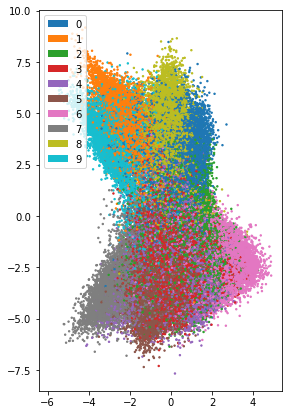

In [17]:
plot_embedding(projected_train, y_train)

In [18]:
labels_train = y_train
shifted_train = projected_train.copy()

for i in range(10):
    shifted_train[labels_train == i] = (1./2. * shifted_train[(labels_train == i)] + 1./4. * shifted_train[(labels_train == i)].mean(axis=0)) + np.array([0.,0.])

In [19]:
# shifted_train[labels_train == 9] += torch.tensor([7.,7.])
# shifted_train[labels_train == 4] += torch.tensor([-2.,7.])

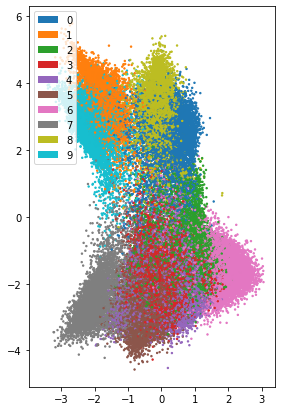

In [20]:
plot_embedding(shifted_train, y_train)

# Retraining

In [21]:
epochs = 4
# tf.random.set_seed(42)

In [27]:
# model_classifier = tf.keras.models.load_model("models/cifar10-before.h5")
model_classifier = functions.get_model("cifar10", optim=tf.keras.optimizers.Adam())
model_classifier.load_weights("models/cifar10-before.h5")

embedder = functions.get_model('umap', save_path='models/cifar10-pumap', optim=tf.keras.optimizers.Adam(), batch_size=500, epochs=2)
model_embedder = embedder.encoder

Wed Oct 28 11:34:22 2020 Building and compiling search function
Pickle of ParametricUMAP model loaded from models/cifar10-pumap\model.pkl
Keras encoder model loaded from models/cifar10-pumap\encoder_model.h5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Cell is empty
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Cell is empty
Keras full model loaded from models/cifar10-pumap\parametric_model.h5


In [28]:
model_embedder = tf.keras.Model(model_embedder.inputs, model_embedder.outputs, name="embedder")
model_embedder.summary()

Model: "embedder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1_input (InputLayer) [(None, 10)]              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
z (Dense)                    (None, 2)                 202       
Total params: 21,502
Trainable params: 21,502
Non-trainable params: 0
______________________________________________________

In [29]:
# we do not want to train the embedding network!
model_embedder.trainable = False

In [30]:
embedder_out = model_embedder(model_classifier.get_layer(layer_key).output)
model_comb = tf.keras.Model(model_classifier.input, [model_classifier.output, embedder_out])
# model_comb.summary()

In [31]:
# train network using the altered embedded points
model_comb.compile(
    optimizer=tf.keras.optimizers.Adam(0.001), #tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),  # sgd does not work with this keras model (it works at least a bit, if lr=0.001)
    # Loss function to minimize
    loss={"classifier": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "embedder": tf.keras.losses.MeanSquaredError()},
    loss_weights={"classifier": 1.0, "embedder": 1.0},
    # List of metrics to monitor
    metrics={"classifier": ['accuracy']},
)

history = model_comb.fit(
    x=X_train,
    y={"classifier": y_train, "embedder": shifted_train},
    batch_size=50,
    epochs=epochs,
    shuffle=True
)

model_comb.save('models/cifar10-after.h5')

Train on 50000 samples
Epoch 1/4
50000/50000 [==============================] - 8s 164us/sample - loss: 1.2374 - classifier_loss: 0.8563 - embedder_loss: 0.3811 - classifier_accuracy: 0.7072
Epoch 2/4
50000/50000 [==============================] - 7s 142us/sample - loss: 1.1150 - classifier_loss: 0.7874 - embedder_loss: 0.3276 - classifier_accuracy: 0.7284
Epoch 3/4
50000/50000 [==============================] - 7s 143us/sample - loss: 1.0572 - classifier_loss: 0.7456 - embedder_loss: 0.3116 - classifier_accuracy: 0.7421
Epoch 4/4
50000/50000 [==============================] - 7s 144us/sample - loss: 1.0150 - classifier_loss: 0.7121 - embedder_loss: 0.3029 - classifier_accuracy: 0.7574


In [32]:
history.history

{'loss': [1.2374314385056495,
  1.1149848128557205,
  1.05718581867218,
  1.0149852333068847],
 'classifier_loss': [0.856346, 0.7873832, 0.74563295, 0.712122],
 'embedder_loss': [0.38108516, 0.32760167, 0.3115531, 0.3028632],
 'classifier_accuracy': [0.70724, 0.72842, 0.74206, 0.75736]}

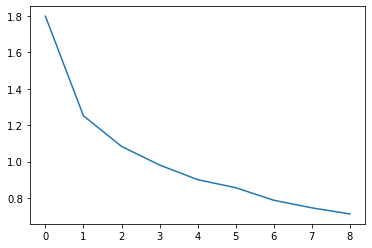

In [33]:
loss = [1.7988359526395798,
  1.2514342765808106,
  1.0833527555465698,
  0.9810658817887307,
  0.9004441791772843,
    0.856346, 0.7873832, 0.74563295, 0.712122]

plt.plot(loss)

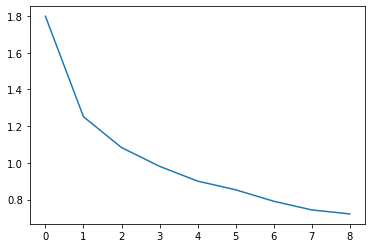

In [46]:
# {'loss': [1.7988359526395798,
#   1.2514342765808106,
#   1.0833527555465698,
#   0.9810658817887307,
#   0.9004441791772843],
#  'accuracy': [0.3989, 0.55544, 0.6219, 0.65852, 0.68768]}

loss = [1.7988359526395798,
  1.2514342765808106,
  1.0833527555465698,
  0.9810658817887307,
  0.9004441791772843,
    0.85313386, 0.7907405, 0.74342877, 0.72164077]

plt.plot(loss)

In [37]:
# train network as usual, for better comparability
model_classifier = functions.get_model("cifar10", optim=tf.keras.optimizers.Adam())
model_classifier.load_weights("models/cifar10-before.h5")
model_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(0.001), #tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),  # sgd does not work with this keras model (it works at least a bit, if lr=0.001)
    # Loss function to minimize
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # List of metrics to monitor
    metrics=['accuracy'],
)
history = model_classifier.fit(
    x=X_train,
    y= y_train,
    batch_size=50,
    epochs=epochs,
    shuffle=True
)

model_classifier.save('models/cifar10-after-baseline.h5')

Train on 50000 samples
Epoch 1/4
50000/50000 [==============================] - 7s 138us/sample - loss: 0.8483 - accuracy: 0.7071
Epoch 2/4
50000/50000 [==============================] - 6s 128us/sample - loss: 0.7927 - accuracy: 0.7245
Epoch 3/4
50000/50000 [==============================] - 6s 130us/sample - loss: 0.7501 - accuracy: 0.7377
Epoch 4/4
50000/50000 [==============================] - 6s 128us/sample - loss: 0.7179 - accuracy: 0.7516


In [38]:
history.history

{'loss': [0.8482969668805599,
  0.792703585267067,
  0.7500532974600792,
  0.7178624502122403],
 'accuracy': [0.70708, 0.72448, 0.73766, 0.75164]}

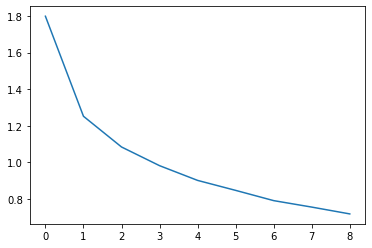

In [36]:
loss = [1.7988359526395798,
  1.2514342765808106,
  1.0833527555465698,
  0.9810658817887307,
  0.9004441791772843,
  0.8458426658809185,
  0.7897358538508416,
  0.7543726064860821,
  0.7170187547802925]

plt.plot(loss)

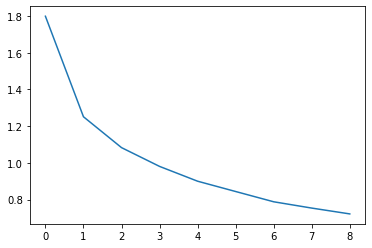

In [49]:
# {'loss': [1.7988359526395798,
#   1.2514342765808106,
#   1.0833527555465698,
#   0.9810658817887307,
#   0.9004441791772843],
#  'accuracy': [0.3989, 0.55544, 0.6219, 0.65852, 0.68768]}

loss = [1.7988359526395798,
  1.2514342765808106,
  1.0833527555465698,
  0.9810658817887307,
  0.9004441791772843,
  0.844303885281086,
  0.7884068651497365,
  0.754086831599474,
  0.7223107630312443]

plt.plot(loss)

#### calculate output for train and test sets over all methods

In [30]:
# outputs for initial model (trained for 5 epochs)
model_classifier = tf.keras.models.load_model("models/cifar10-before.h5")
model_sub = tf.keras.Model(inputs=model_classifier.inputs, outputs=model_classifier.get_layer(layer_key).output)
embedder = load_ParametricUMAP('models/cifar10-pumap')
model_embedder = embedder.encoder

logits_train_before = model_classifier.predict(X_train)
projected_train_before = model_embedder.predict(model_sub.predict(X_train))
logits_test_before = model_classifier.predict(X_test)
projected_test_before = model_embedder.predict(model_sub.predict(X_test))


Fri Oct 23 11:27:25 2020 Building and compiling search function
Pickle of ParametricUMAP model loaded from models/cifar10-pumap\model.pkl
Keras encoder model loaded from models/cifar10-pumap\encoder_model.h5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Cell is empty
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Cell is empty
Keras full model loaded from models/cifar10-pumap\parametric_model.h5


In [31]:
# outputs for baseline model (trained for 5 + 4 epochs)
model_classifier = tf.keras.models.load_model("models/cifar10-after-baseline.h5")
model_sub = tf.keras.Model(inputs=model_classifier.inputs, outputs=model_classifier.get_layer(layer_key).output)
embedder = load_ParametricUMAP('models/cifar10-pumap')
model_embedder = embedder.encoder

logits_train_baseline = model_classifier.predict(X_train)
projected_train_baseline = model_embedder.predict(model_sub.predict(X_train))
logits_test_baseline = model_classifier.predict(X_test)
projected_test_baseline = model_embedder.predict(model_sub.predict(X_test))


Fri Oct 23 11:27:37 2020 Building and compiling search function
Pickle of ParametricUMAP model loaded from models/cifar10-pumap\model.pkl
Keras encoder model loaded from models/cifar10-pumap\encoder_model.h5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Cell is empty
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Cell is empty
Keras full model loaded from models/cifar10-pumap\parametric_model.h5


In [32]:
# outputs for model using latent interventions (trained for 5 + 4 epochs)
model_combined = tf.keras.models.load_model("models/cifar10-after.h5")

logits_train_after, projected_train_after = model_combined.predict(X_train)
logits_test_after, projected_test_after = model_combined.predict(X_test)


# Evaluation

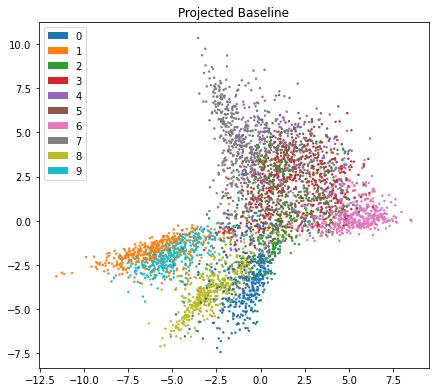

In [33]:
plot_embedding(projected_train_baseline[::12], y_train[::12], "Projected Baseline")

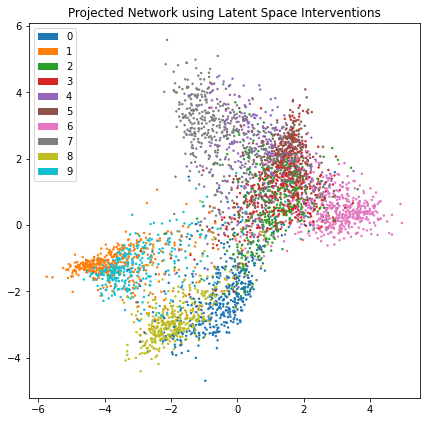

In [34]:
plot_embedding(projected_train_after[::12], y_train[::12], "Projected Network using Latent Space Interventions")

In [35]:
def get_cf(y, logits):
    cf = np.zeros((10,10), dtype="int64")
    for i in zip(y, logits.argmax(1)):
        cf[i] += 1
    return cf

In [36]:
cf_train_before = get_cf(y_train, logits_train_before)

cf_test_before = get_cf(y_test, logits_test_before)

In [37]:
cf_train_baseline = get_cf(y_train, logits_train_baseline)

cf_test_baseline = get_cf(y_test, logits_test_baseline)

In [38]:
cf_train_altered = get_cf(y_train, logits_train_after)

cf_test_altered = get_cf(y_test, logits_test_after)

In [39]:
# baseline accuracy
np.diag(cf_test_baseline).sum() / cf_test_baseline.sum()

0.6948

In [40]:
# intervention accuracy
np.diag(cf_test_altered).sum() / cf_test_altered.sum()

0.6984

In [41]:
cf_test_before

array([[687,  13,  41,  33,  16,   7,  19,  11, 100,  73],
       [ 15, 749,   4,  11,   2,   7,  10,   2,  35, 165],
       [ 70,   7, 449, 131, 100, 105,  74,  26,  21,  17],
       [ 14,   5,  28, 577,  40, 200,  47,  30,  21,  38],
       [ 14,   6,  26, 131, 614,  48,  56,  81,  16,   8],
       [  4,   2,  21, 203,  39, 649,  17,  33,   5,  27],
       [  2,   4,  24, 112,  53,  28, 738,   7,   6,  26],
       [ 15,   2,  18,  83,  60,  75,   6, 708,   4,  29],
       [ 64,  16,  12,  16,   8,   7,   3,   3, 802,  69],
       [ 15,  32,   7,  16,   5,   6,  10,   3,  25, 881]], dtype=int64)

In [42]:
cf_test_baseline

array([[690,  44,  76,  10,  21,   0,  12,  12,  95,  40],
       [ 14, 884,   4,   5,   2,   0,   8,   2,  19,  62],
       [ 57,  16, 561,  53,  68,  39, 128,  49,  16,  13],
       [ 35,  23,  70, 473,  90,  90, 115,  42,  23,  39],
       [ 15,   7,  70,  57, 656,  16,  96,  63,  11,   9],
       [ 20,   4,  53, 195,  60, 491,  54,  92,  20,  11],
       [  8,   9,  31,  42,  27,   8, 856,   7,   3,   9],
       [ 26,  10,  48,  21,  78,  28,  22, 737,   6,  24],
       [ 70,  51,  16,  10,   8,   2,   8,   6, 776,  53],
       [ 24,  83,   8,   9,   3,   3,   8,  10,  28, 824]], dtype=int64)

In [43]:
cf_test_altered

array([[719,  19,  62,  16,  26,   8,   6,  16, 109,  19],
       [ 16, 833,   7,   4,   7,   9,   7,   2,  50,  65],
       [ 60,   9, 617,  69,  79,  56,  61,  26,  13,  10],
       [ 20,  14, 113, 504,  93, 121,  56,  42,  21,  16],
       [ 15,   6, 101,  63, 673,  26,  40,  64,  11,   1],
       [  3,   6, 103, 220,  50, 547,  13,  42,   5,  11],
       [  5,   8,  75,  53,  66,  17, 759,  10,   4,   3],
       [ 16,   1,  63,  47,  70,  52,   5, 732,   1,  13],
       [ 69,  28,  15,  14,   7,   5,   9,   6, 820,  27],
       [ 32,  60,  14,  12,  15,   6,  11,  14,  56, 780]], dtype=int64)

In [44]:
def prec(cf, l):
    return cf[l,l] / cf[:,l].sum()
def rec(cf, l):
    return cf[l,l] / cf[l,:].sum()
def f1(cf, l):
    return 2 * prec(cf, l) * rec(cf, l) / (prec(cf, l) + rec(cf, l))

In [45]:
# print(prec(cf_test_baseline, 3))
# print(rec(cf_test_baseline, 3))
# print(f1(cf_test_baseline, 3))

# print(prec(cf_test_baseline, 8))
# print(rec(cf_test_baseline, 8))
# print(f1(cf_test_baseline, 8))

print(f1(cf_test_baseline, 4))
print(f1(cf_test_baseline, 9))

0.6517635370094387
0.7907869481765835


In [46]:
# print(prec(cf_test_altered, 3))
# print(rec(cf_test_altered, 3))
# print(f1(cf_test_altered, 3))

# print(prec(cf_test_altered, 8))
# print(rec(cf_test_altered, 8))
# print(f1(cf_test_altered, 8))

print(f1(cf_test_altered, 4))
print(f1(cf_test_altered, 9))

0.6452540747842762
0.8020565552699229
